In [15]:
import sys
sys.path.append('../')

import pandas as pd
from src.utils.preprocessing import (load_data,
                                    save_data,
                                    build_combined_discharge,
                                    get_bhc_input,
                                    extract_clean_inputs,
                                    remove_itemize_patterns,
                                    remove_underscores,
                                    replace_brackets)

from src.utils.token_count import get_token_count, plot_token_count
from tqdm import tqdm
tqdm.pandas()

%load_ext autoreload
%autoreload 2


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring celaning pipepline on the test set. 

**Loading data**

In [18]:
data_path = '../data/'

In [19]:
test_discharge = load_data(data_path + 'test_phase_1/discharge.csv.gz')
test_targets = load_data(data_path + 'test_phase_1/discharge_target.csv.gz')


**Merging**

In [20]:
test_combined_discharge = build_combined_discharge(test_discharge, test_targets)

**Counting invariants**

In [21]:
test_combined_discharge['bhc_token_count'] = test_combined_discharge['brief_hospital_course'].progress_apply(get_token_count)
test_combined_discharge['di_token_count'] = test_combined_discharge['discharge_instructions'].progress_apply(get_token_count)

100%|██████████| 14702/14702 [00:31<00:00, 473.25it/s]


**Stage0: Origninal BHC input**

i.e. **ALL** the discharge before the BHC

100%|██████████| 14702/14702 [03:06<00:00, 78.95it/s] 


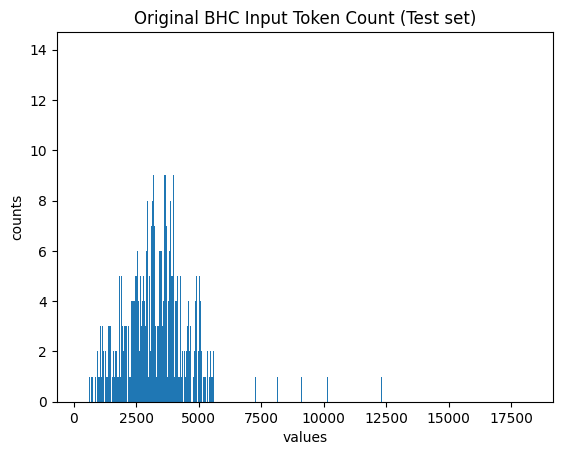

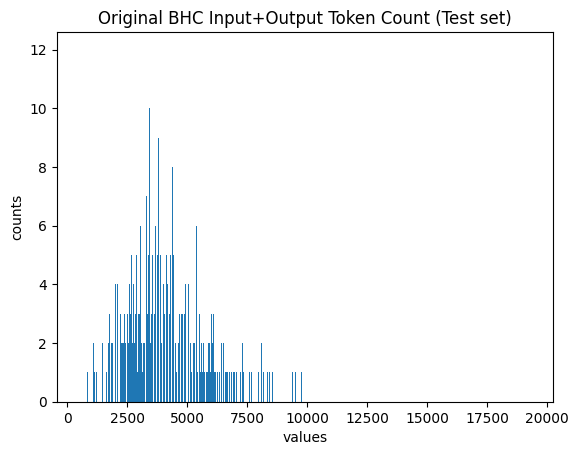

In [22]:
test_combined_discharge['original_bhc_input'] = get_bhc_input(test_combined_discharge)
test_combined_discharge['orginal_bhc_input_token_count'] = test_combined_discharge['original_bhc_input'].progress_apply(get_token_count)
plot_token_count(test_combined_discharge['orginal_bhc_input_token_count'],
                'Original BHC Input Token Count (Test set)')
plot_token_count(test_combined_discharge['orginal_bhc_input_token_count'] + test_combined_discharge['bhc_token_count'] , 
                'Original BHC Input+Output Token Count (Test set)')

**Stage1: First cleaning by extraction (By Haotian)**
i.e. keep and organize relevent sections without looking to much in details

In [23]:
clean1_bhc_input = extract_clean_inputs(test_combined_discharge,
                        features_to_include=[
                                'sex',
                                'allergies',
                                'chief_complaint',
                                'major_surgical_procedures',
                                'history_of_present_illness',
                                'past_medical_history',
                                'social_history',
                                'family_history',
                                'physical_exam',
                                'pertinent_results',
                            ])

100%|██████████| 14702/14702 [02:01<00:00, 121.17it/s]


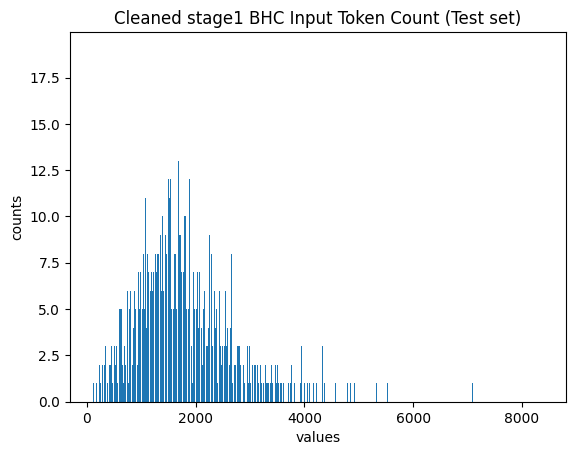

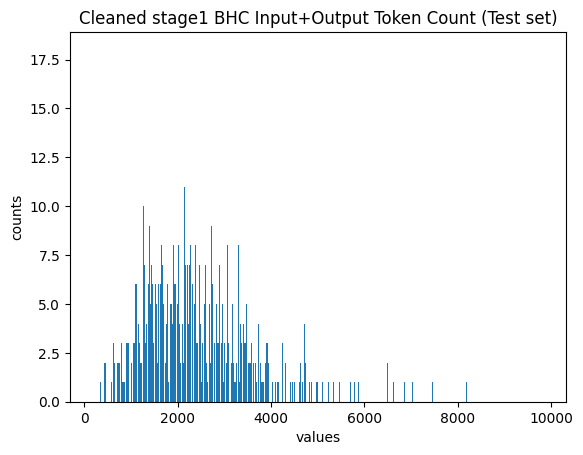

In [24]:
clean_1_bhc_input_token_count = clean1_bhc_input.progress_apply(get_token_count)
plot_token_count(clean_1_bhc_input_token_count,
                 'Cleaned stage1 BHC Input Token Count (Test set)')
plot_token_count(clean_1_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                 'Cleaned stage1 BHC Input+Output Token Count (Test set)')

In [26]:
print(clean1_bhc_input[clean_1_bhc_input_token_count.idxmax()])

Sex: 
M
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Chief Complaint: 
Compartment syndrome 

Major Surgical or Invasive Procedure: 
___ Left lower and upper extremity fasciotomies
___ Left lower extremity debridement, Left medial thigh 
closure
___ Left lower extremity debridement
___ Left lower extremity debridement

History of Present Illness: 
___ presents to an OSH with significantly increasing left lower 
extremity pain, numbness and tingling.  Patient reports passing 
out at home two days ago,
after drinking, and waking up one day prior to admission, with 
numbness and tingling in the left foot. He reports increasingly 
worsening pain, with loss of function and sensation. He also 
reports a painful rash which started in the left lower extremity 
extended upward into the groin and abdomen. There are also some 
blisters on this rash.   He reports otherwise being in his usual 
state of health.  

Past Medical History: 
IV drug abuse, bilateral inguinal hernias as a c

**Stage2 :Removing 'pertinent results' section**
- Does not seem relevent or the task
- Lots of tokens like "---", digits etc 

In [27]:
clean2_bhc_input = extract_clean_inputs(test_combined_discharge,
                            features_to_include=[
                                'sex',
                                'allergies',
                                'chief_complaint',
                                'major_surgical_procedures',
                                'history_of_present_illness',
                                'past_medical_history',
                                'social_history',
                                'family_history',
                                #'physical_exam',
                            ])                                        


100%|██████████| 14702/14702 [00:44<00:00, 329.85it/s]


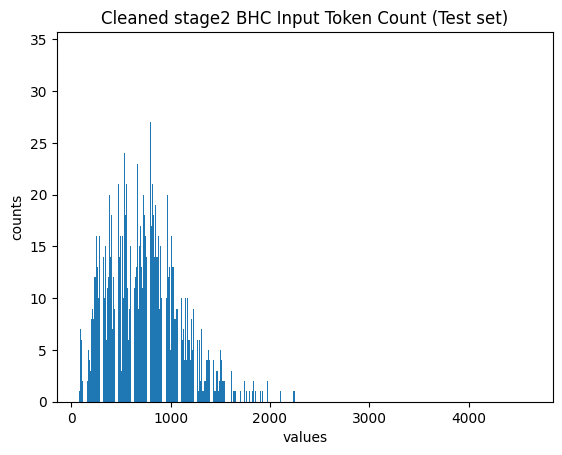

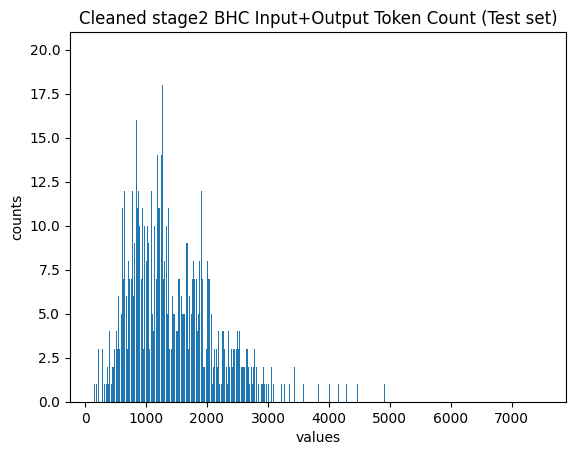

In [28]:
clean2_bhc_input_token_count = clean2_bhc_input.progress_apply(get_token_count)
plot_token_count(clean2_bhc_input_token_count,
                 'Cleaned stage2 BHC Input Token Count (Test set)')
plot_token_count(clean2_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                    'Cleaned stage2 BHC Input+Output Token Count (Test set)')


**Stage3 cleaning of specific token groups**
- Replacing "____" by "__"
- Replacing "-___:" by "-"
- other ?




100%|██████████| 14702/14702 [00:40<00:00, 358.92it/s]


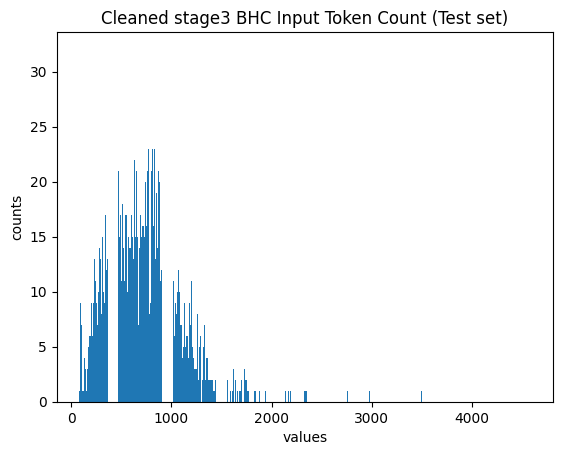

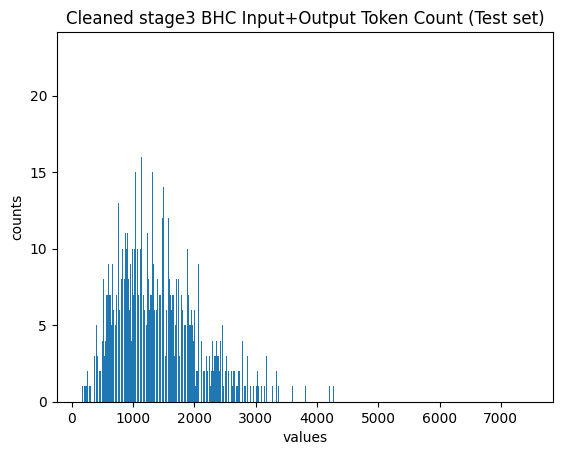

In [29]:
clean3_bhc_input= clean2_bhc_input.progress_apply(remove_itemize_patterns).progress_apply(remove_underscores) 

clean3_bhc_input_token_count = clean3_bhc_input.progress_apply(get_token_count)
plot_token_count(clean3_bhc_input_token_count,
                 'Cleaned stage3 BHC Input Token Count (Test set)')
plot_token_count(clean3_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                    'Cleaned stage3 BHC Input+Output Token Count (Test set)')


In [32]:
i = clean3_bhc_input_token_count.idxmax()
print(clean2_bhc_input[i])
print('\n\n===============\n\n')
print(clean3_bhc_input[i])

print(test_combined_discharge['discharge_instructions'][i])

Sex: 
M
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Chief Complaint: 
Shortness of breath

Major Surgical or Invasive Procedure: 
___ ___
___ Cardiac catheterization
___ pMIBI___ ___
___ Cardiac catheterization

Pending Results at Discharge: 
Microbiology
___ 19:24  BLOOD CULTURE Blood Culture, Routine
___ 19:22  BLOOD CULTURE Blood Culture, Routine
___ 11:38  BLOOD CULTURE Blood Culture, Routine
___ 08:44  BLOOD CULTURE Blood Culture, Routine
Diagnostic Reports
___ C.CATH

Key Information for Outside Providers: 
___ is a ___ year old male with past medical history of 
alcohol abuse in remission, prior alcoholic pancreatitis 
complicated by chronic pancreatic insufficiency, prior tobacco 
abuse with COPD, admitted ___ with severe iron-deficiency 
anemia, shock liver, requiring emergent transfusion, course 
complicated by new acute systolic CHF, found to have 2-vessel 
CAD and coronary aneurysm, recommended for CABG, but declining 
inpatient intervention, discharged home

**More Exploration**
- Remove Brackets []

 41%|████▏     | 6096/14702 [00:00<00:00, 27794.77it/s]

100%|██████████| 14702/14702 [00:44<00:00, 330.89it/s]


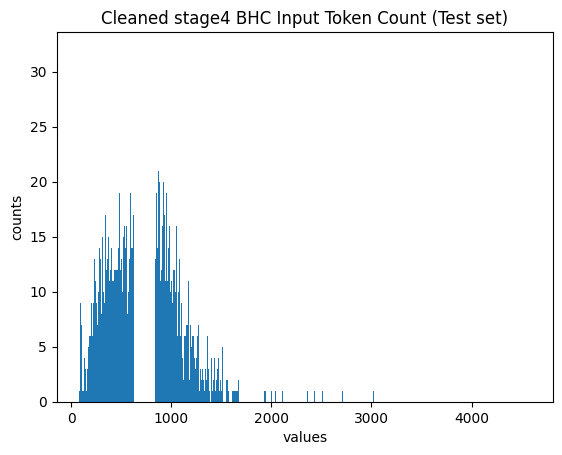

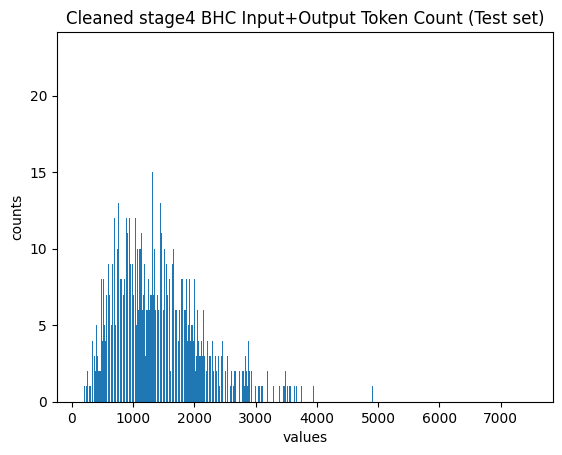

In [31]:
clean4_bhc_input= clean3_bhc_input.progress_apply(replace_brackets) 

clean4_bhc_input_token_count = clean4_bhc_input.progress_apply(get_token_count)
plot_token_count(clean4_bhc_input_token_count,
                 'Cleaned stage4 BHC Input Token Count (Test set)')
plot_token_count(clean4_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                    'Cleaned stage4 BHC Input+Output Token Count (Test set)')

In [14]:
discharges_train_target_count = discharges_train_target_df.duplicated(subset=['hadm_id']).sum()
discharges_valid_target_count = discharges_valid_target_df.duplicated(subset=['hadm_id']).sum()
print("Number of duplicate hadm_id in train:", discharges_train_target_count)
print("Number of duplicate hadm_id in valid:", discharges_valid_target_count)

NameError: name 'discharges_train_target_df' is not defined

In [ ]:
discharges_valid_df_count = discharges_valid_df.duplicated(subset=['hadm_id']).sum()
discharges_train_df_count = discharges_train_df.duplicated(subset=['hadm_id']).sum()
print("Number of duplicate hadm_id in train:", discharges_train_df_count)
print("Number of duplicate hadm_id in valid:", discharges_valid_df_count)


Number of duplicate hadm_id in train: 0
Number of duplicate hadm_id in valid: 0


In [ ]:
combined_discharge_train_df = pd.merge(discharges_train_df[['hadm_id', 'text']],
                                discharges_train_target_df[['hadm_id', 'discharge_instructions', 'brief_hospital_course']],
                                on='hadm_id',
                                how='inner')

In [ ]:
len(combined_discharge_train_df)

68785

In [ ]:
combined_discharge_train_df.head()

,hadm_id,text,discharge_instructions,brief_hospital_course
0,22841357,\nName: ___ Unit No: _...,"Dear ___,\n\n___ was a pleasure to take care o...","___ with HIV on HAART, HCV cirrhosis with asci..."
1,22927623,\nName: ___ Unit No: ___\n...,"Dear Ms. ___,\n\nYou were hospitalized at ___....",Ms. ___ is a ___ with history of GERD who pres...
2,21738619,\nName: ___ Unit No: ___...,"Dear ___, \n\n___ were seen in the ED for ongo...",___ Female with PMH significant for depression...
3,25849114,\nName: ___ Unit No: ___...,"Dear Ms. ___,\nIt was a pleasure taking part i...",Ms. ___ is a ___ with metastatic cancer of unk...
4,29654838,\nName: ___ Unit No: ___\n \nAdmi...,"Dear Ms. ___, \n\nYou were admitted for shortn...","___ woman with h/o hypertension, hypelipidemia..."


In [ ]:
print(combined_discharge_train_df['text'][2])

 
Name:  ___                   Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Sulfa (Sulfonamide Antibiotics) / Codeine / Bactrim
 
Attending: ___
 
Chief Complaint:
nausea, vomiting, cough
 
Major Surgical or Invasive Procedure:
none

 
History of Present Illness:
___ female, with past medical history significant for 
depression, hyperlipidemia, Hysterectomy, B12 deficiency, back 
pain, carcinoid, cervical DJD, depression, hyperlipidemia, 
osteoarthritis, and history of Exploratory laparotomy, lysis of 
adhesions, and small bowel resection with enteroenterostomy for 
a high grade SBO ___ who presents with nausea, vomiting, 
weakness x 2 weeks. She has been uable to tolerate PO liquids, 
and solids. Had similar presentation ___ for high grade SBO. 
Denies passing flatus today. However reports having last normal 
bowel movement this AM, without hematochezia, melena. Also 
reporting sub

In [ ]:
print(combined_discharge_train_df['discharge_instructions'][0])

Dear ___,

___ was a pleasure to take care of you at ___ 
___. You were admitted with abdominal fullness and 
pain from your ascites. You had a diagnostic and therapeutic 
paracentesis with 4.3 L removed. Your spironolactone was 
discontinued because your potassium was high. Your lasix was 
increased to 40mg daily. You are scheduled for another 
paracentesis on ___ prior to your other appointments that day. 
Please call tomorrow to find out the time of the paracentesis. 
Please continue to follow a low sodium diet and fluid 
restriction. You should call your liver doctor or return to the 
emergency room if you have abdominal pain, fever, chills, 
confusion, or other concerning symptoms.

Sincerely,
Your ___ medical team


In [ ]:
print(combined_discharge_train_df['brief_hospital_course'][0])

___ with HIV on HAART, HCV cirrhosis with ascites and HE, h/o 
IVDU, COPD, bipolar disorder presents with abdominal discomfort 
due to ___ ascites.  
 
# ASCITES. Now diuretic refractory given last tap was three days 
ago with 3L removed and she has already built up moderate 
ascites. Infectious workup negative, with CXR clear, UA 
contaminated but not grossly positive so will f/u culture, 
diagnostic para with only 225 WBC, RUQ US with no PV thrombus. 
Compliant with diuretics but not following low sodium diet or 
fluid restriction. Dr. ___ discussed possible TIPS in 
the office but due to lung disease, that was on hold pending 
further cardiac evaluation. Diuretics were recently decreased 
due to hyponatremia and hyperkalemia. Held spironolactone for 
now due to K 5.2 and increased lasix 20 -> 40. No evidence of 
severe hyponatremia (Na<120) or renal failure Cr>2.0 to stop 
diuretics at present. Diagnostic paracentesis negative for 
infection. Ascitic total protein 0.3 so warrants SB

In [ ]:
combined_discharge_valid_df = pd.merge(discharges_valid_df[['hadm_id', 'text']],
                                discharges_valid_target_df[['hadm_id', 'discharge_instructions', 'brief_hospital_course']],
                                on='hadm_id',
                                how='inner')

In [ ]:
len(combined_discharge_valid_df)

14719

In [ ]:
combined_discharge_df = pd.concat([combined_discharge_train_df, combined_discharge_valid_df], ignore_index=True)

In [ ]:
len(combined_discharge_df)

83504

In [ ]:
def extract_pertinent_text(text):
    Pertinent_Results = re.findall(r'Pertinent Results:\s*\n{0,2}(.*?)(?=\n\s*\n{0,2}\s*[A-Z_]+[^\n:]+:\n)', text, re.DOTALL)
    # Concatenate the extracted texts and return
    Pertinent_Results_text = "Pertinent Results: \n" + ''.join(Pertinent_Results)
    return Pertinent_Results_text

combined_discharge_pertinent_df = pd.DataFrame()  # Define the DataFrame
combined_discharge_pertinent_df['input_pertinent_text'] = combined_discharge_df['text'].apply(extract_pertinent_text)